# ディープラーニングをスクラッチする課題

# 【問題1】全結合層のクラス化

In [148]:
import numpy as np
from copy import deepcopy

class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.Z = 0
        self.dA = 0

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.Z = deepcopy(X)
        A = np.dot(X, self.W) + self.B
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dA = deepcopy(dA)
        dW = np.dot(self.Z.T, dA)
        dZ = np.dot(dA, self.W.T) 
        # 更新
        self = self.optimizer.update(self)
        
        return dZ

# 【問題2】初期化方法のクラス化
# 【問題6】重みの初期値

In [358]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape(n_nodes1, n_nodes2)
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W.astype("f")
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape(1, nodes2)
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B.astype("f")
    
class XavierInitializer:
    """
    Xavierによる初期化
    Sigmoid」かTanhに向いている
    """
    
    def __init__(self):
        self.sigma = None
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape(n_nodes1, n_nodes2)
        """
        self.sigma = 1 / np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W.astype("f")
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape(1, nodes2)
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B.astype("f")
    
class HeInitializer:
    """
    Heによる初期化
    ReLUと相性がいい
    """
    
    def __init__(self):
        self.sigma = 0
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape(n_nodes1, n_nodes2)
        """
        self.sigma = np.sqrt(2 / n_nodes1)
        W = (self.sigma * np.random.randn(n_nodes1, n_nodes2))
        return W.astype("f")
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape(1, nodes2)
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B.astype("f")

# 【問題3】最適化手法のクラス化
 # 【問題7】最適化手法

In [410]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.W[...] = layer.W - self.lr * np.dot(layer.Z.T, layer.dA) / len(layer.dA)
        layer.B[...] = layer.B - self.lr * np.mean(layer.dA, axis=0)
        return layer

class AdaGrad:
    """
    学習率を変化を減少させていく勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        self.HW = 0
        self.HB = 0
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        
        dW = np.dot(layer.Z.T, layer.dA) / len(layer.dA)
        dB = np.mean(layer.dA, axis=0)
        self.HW += dW**2
        self.HB +=  dB**2
        layer.W[...] = layer.W - self.lr / np.sqrt(self.HW +1e-7) * dW #0で割るとまずいので +le-7
        layer.B[...] = layer.B - self.lr / np.sqrt(self.HB + 1e-7)  * dB
        return layer
    
class Momentum:
    
    """
    momentumSGD
    Parameters
    ----------
    lr : 学習率
    momentum : 学習係数
    """
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.vW = 0
        self.vB = 0
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """

        dW = np.dot(layer.Z.T, layer.dA) / len(layer.dA)
        dB = np.mean(layer.dA, axis=0)
        
        self.vW = self.momentum * self.vW - self.lr * dW
        self.vB =  self.momentum * self.vB - self.lr * dB
        
        layer.W[...] = layer.W + self.vW
        layer.B[...] = layer.B + self.vB
        
        return layer
    
class Adam:

    """
    Adam
    RMSprop に Momentum 法を組み合わせたような形
    Parameters
    ----------
    lr : 学習率
    momentum : 学習係数
    beta1
    beta2
    """

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.mW = 0
        self.vW = 0
        self.mB = 0
        self.vB = 0
        
    def update(self, layer):
        
        self.iter += 1
        dW = np.dot(layer.Z.T, layer.dA) / len(layer.dA)
        dB = np.mean(layer.dA, axis=0)
        
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter) 
        
        self.mW += (1 - self.beta1) * (dW - self.mW)
        self.vW += (1 - self.beta2) * (dW**2 - self.vW)
        self.mB += (1 - self.beta1) * (dB - self.mB)
        self.vB += (1 - self.beta2) * (dB**2 - self.vB)
        
        layer.W -= lr_t * self.mW / (np.sqrt(self.vW) + 1e-7)
        layer.B -= lr_t * self.mB / (np.sqrt(self.vB) + 1e-7)

# 【問題4】活性化関数のクラス化
# 【問題5】ReLUクラスの作成

In [151]:
class sigmoid:
    """
    シグモイド関数
    """
    
    def __init__(self):
        self.Z = 0
    
    def forward(self, A):
        """
        フォワード
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes)
            入力
        Returns
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes)
            出力
        """ 
        Z = 1 / (1 + np.exp(-A))
        self.Z = Z
        return Z
    
    def backward(self, dZ):
        """
        バックワード
        Parameters
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes)
            後ろから流れてきた勾配
        Returns
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes)
            前に流す勾配
        """
        dA = dZ  *  (1 - self.Z) * self.Z 
        return dA
    
class Tanh:
    """
    ハイパボリックタンジェント関数
    """
    
    def __init__(self):
        self.Z = 0
    
    def forward(self, A):
        """
        フォワード
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes)
            入力
        Returns
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes)
            出力
        """ 
        Z = np.tanh(A)
        self.Z = Z
        return Z
    
    def backward(self, dZ):
        """
        バックワード
        Parameters
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes)
            後ろから流れてきた勾配
        Returns
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes)
            前に流す勾配
        """
        dA = dZ  *  (1 - self.Z**2)
        return dA

class Softmax:
    """
    ソフトマックス関数
    """
    
    def __init__(self):
        self.Z = 0
    
    def forward(self, A):
        """
        フォワード
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes)
            入力
        Returns
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes)
            出力
        """ 
        
        c = np.max(A)
        A = A - c
        ex = np.exp(A)
        Z = ex / (np.sum(ex, axis=1))[:, np.newaxis]
        self.Z = Z
        return Z
    
    def backward(self, y):
        """
        バックワード
        Parameters
        ----------
        y : 次の形のndarray, shape (batch_size, n_class)
            正解ラベル
        Returns
        ----------
        dA : 次の形のndarray, shape (batch_size, n_class)
            前に流す勾配
        """
        
        dA = self.Z - y
        
        return dA
    
class ReLU:
    """
    ReLU関数
    """
    
    def __init__(self):
        self.Z = None
    
    def forward(self, A):
        """
        フォワード
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes)
            入力
        Returns
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes)
            出力
        """ 
        Z = np.maximum(0, A)
        self.Z = deepcopy(Z)
        return Z
    
    def backward(self, dZ):
        """
        バックワード
        Parameters
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes)
            後ろから流れてきた勾配
        Returns
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes)
            前に流す勾配
        """
        
        dA = dZ  *  np.where(self.Z != 0, 1, self.Z)
        
        return dA


In [152]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop
    
    #Pythonの特殊メソッドのひとつで、オブジェクトに角括弧でアクセスしたときの挙動を定義できる。
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [153]:
#これは使ってません
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

class ScratchDeepNeuralNetrowkClassifier:
    """
    """
    
    def __init__(self, n_nodes1, n_nodes2, n_output, sigma=0.01, lr=0.01, batch_size=50, epoch=10, verbose=True, metrics="acc"):
        self.sigma = sigma
        self.lr = lr
        self.n_features = 0
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.batch_size = batch_size
        self.epoch = epoch
        self.metrics = metrics
        self.verbose = verbose
        self.train_loss = np.zeros(epoch)
        self.val_loss = np.zeros(epoch)
        self.layers = []
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        
        # self.sigma : ガウス分布の標準偏差
        # self.lr : 学習率
        # self.n_nodes1 : 1層目のノード数
        # self.n_nodes2 : 2層目のノード数
        # self.n_output : 出力層のノード数
        self.n_features = X.shape[1]

        optimizer = SGD(self.lr)
        #optimizer = AdaGrad(self.lr)
        #Initializer = SimpleInitializer()
        Initializer = HeInitializer()
        
        FC1 = FC(self.n_features, self.n_nodes1, Initializer, optimizer)
        activation1 = ReLU()
        FC2 = FC(self.n_nodes1, self.n_nodes2, Initializer, optimizer)
        activation2 = ReLU()
        FC3 = FC(self.n_nodes2, self.n_output, Initializer, optimizer)
        activation3 = Softmax()
        
        self.construction(FC1)
        self.construction(activation1)
        self.construction(FC2)
        self.construction(activation2)
        self.construction(FC3)
        self.construction(activation3)
        
        #self.construction(FC(self.n_features, self.n_nodes1, Initializer, optimizer))
        #self.construction(ReLU())
        #self.construction(b)
        #self.construction(FC(self.n_nodes1, self.n_nodes2, Initializer, optimizer))
        #self.construction(ReLU())
        #self.construction(FC(self.n_nodes2, self.n_output, Initializer, optimizer))
        #self.construction(Softmax())
        
        for i in range(self.epoch):

            #バッチ作成
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=56)

            for mini_X_train, mini_y_train in get_mini_batch:
                
                #FP
                self.FP(mini_X_train)

                #BP
                self.BP(mini_y_train)
                
            #評価値の表示
            train_pred = self.FP(X)
            self.train_loss[i] = self._cross_entropy_loss(train_pred, y)
            
            if np.any(X_val):
                val_pred = self.FP(X_val)
                self.val_loss[i] = self._cross_entropy_loss(val_pred, y_val)
                met = self.accuracy(np.argmax(y_val, axis=1), np.argmax(val_pred, axis=1))
                      
                if self.verbose:
                    print("epoch:{0} train_loss: {1} val_loss: {2} {3}: {4}".format(i+1, self.train_loss[i], self.val_loss[i], self.metrics, met))
                    
            else:
                if self.verbose:
                      print("epoch:{0} loss: {1}".format(i+1, self.train_loss[i]))
     
    def construction(self, layer):
        self.layers += [layer]
        
    def FP(self, X):
        for layer in self.layers:
            X = layer.forward(X)
            
        return X
            
    def BP(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)
            
    def _cross_entropy_loss(self,z, y):
        z += 0.00000001
        return - sum(sum(y * np.log(z))) / len(y)
    
    def accuracy(self, y, y_pred):
        # accuracyを計算して返す
        return accuracy_score(y, y_pred)

In [443]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

class ScratchDeepNeuralNetrowkClassifier2:
    """
    """
    
    def __init__(self, n_features, batch_size=50, epoch=10, verbose=True, metrics="acc"):
        self.n_nodes = [n_features]
        self.n_output = n_output
        self.batch_size = batch_size
        self.epoch = epoch
        self.metrics = metrics
        self.verbose = verbose
        self.train_loss = []
        self.val_loss = []
        self.layers = []

    
    def add(self, layer_type, n_nodes=None, Initializer=None, optimizer=None):
        
        if layer_type == "FC":
            self.layers += [FC(self.n_nodes[-1], n_nodes, Initializer, optimizer)]
            self.n_nodes += [n_nodes]
            
        elif layer_type == "ReLU":
            self.layers += [ReLU()]
        
        elif layer_type == "Tanh":
            self.layers += [Tanh()]
        
        elif layer_type == "sigmoid":
            self.layers += [sigmoid()]
            
        elif layer_type == "Softmax":
            self.layers += [Softmax()]
        else:
            print("layer_typeが存在しません")
            
    def fit(self, X, y, X_val=None, y_val=None, epoch=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        epoch : int
            エポック数変えたいときは入れてください
        """
        if epoch:
            self.epoch = epoch
        
        for i in range(self.epoch):

            #バッチ作成
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=56)

            for mini_X_train, mini_y_train in get_mini_batch:
                
                #FP
                self.FP(mini_X_train)

                #BP
                self.BP(mini_y_train)
                
            #評価値等の表示
            train_pred = self.FP(X)
            self.train_loss += [self._cross_entropy_loss(train_pred, y)]
            
            if np.any(X_val):
                val_pred = self.FP(X_val)
                self.val_loss += [self._cross_entropy_loss(val_pred, y_val)]
                
                #metricsを判定
                if  self.metrics == "acc":
                    met = self.accuracy(np.argmax(y_val, axis=1), np.argmax(val_pred, axis=1))
                else:
                    print("metricsの入力が間違っています")
                      
                if self.verbose:
                    print("epoch:{0} train_loss: {1} val_loss: {2} {3}: {4}".format(i+1, self.train_loss[i], self.val_loss[i], self.metrics, met))
                    
            else:
                if self.verbose:
                      print("epoch:{0} loss: {1}".format(i+1, self.train_loss[i]))
     
    def FP(self, X):
        for layer in self.layers:
            X = layer.forward(X)
            
        return X
            
    def BP(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)
    
    def predict(self, X):
        hx = self.FP(X)
        return np.argmax(hx, axis=1)
            
    def _cross_entropy_loss(self,z, y):
        z += 1e-7
        return - sum(sum(y * np.log(z))) / len(y)
    
    def accuracy(self, y, y_pred):
        # accuracyを計算して返す
        return accuracy_score(y, y_pred)
    
    def plot_learning_curve(self):
        """
        学習曲線をプロットします。

        loss : array
        一回ごとの勾配降下方のロスのログ(train)
         val_los : array
        一回ごとの勾配降下方のロスのログ(val or test)
        """
        plt.figure(figsize=(8, 5))
        plt.title("model_loss")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.plot(self.train_loss, label="train_loss")
        plt.plot(self.val_loss, label="val_loss")
        #plt.yscale("log")
        plt.legend()

In [337]:
#データのロード
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#フラットにする
X_train = x_train.reshape(-1, 784)
X_test = x_test.reshape(-1, 784)
#スケール合わせ
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255.0
X_test /= 255.0
#onehot
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
#sprit train and val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

In [457]:
n = X_train.shape[1]
model2 = ScratchDeepNeuralNetrowkClassifier2(n_features=n, batch_size=50, epoch=80, verbose=True)

In [458]:
#optimizer = SGD(0.01)
#optimizer1 = AdaGrad(0.01)
#Initializer = SimpleInitializer()
#Initializer = HeInitializer()
#XavierInitializer
#Momentum
#Adam

In [459]:
model2.add("FC", 400, XavierInitializer(), Momentum(0.01, 0.9))
model2.add("Tanh")
model2.add("FC", 400, XavierInitializer(), Momentum(0.01, 0.9))
model2.add("Tanh")
model2.add("FC", 400, XavierInitializer(), Momentum(0.01, 0.9))
model2.add("Tanh")
model2.add("FC", 200, XavierInitializer(), Momentum(0.01, 0.9))
model2.add("Tanh")
model2.add("FC", 200, XavierInitializer(), Momentum(0.01, 0.9))
model2.add("Tanh")
model2.add("FC", 100, XavierInitializer(), Momentum(0.01, 0.9))
model2.add("Tanh")
model2.add("FC", 100, XavierInitializer(), Momentum(0.01, 0.9))
model2.add("Tanh")
model2.add("FC", 10, XavierInitializer(), Momentum(0.01, 0.9))
model2.add("Softmax")

In [460]:
model2.layers

In [461]:
model2.fit(X_train.astype("f"), y_train.astype("f"), X_val, y_val)

epoch:1 train_loss: 0.20406753222147625 val_loss: 0.22625635457227922 acc: 0.9301666666666667
epoch:2 train_loss: 0.13403254699707032 val_loss: 0.16297755913294795 acc: 0.95225
epoch:3 train_loss: 0.08944449551900228 val_loss: 0.12396296458292101 acc: 0.9640833333333333
epoch:4 train_loss: 0.07124495728810629 val_loss: 0.11224698432382942 acc: 0.9673333333333334
epoch:5 train_loss: 0.06567094167073567 val_loss: 0.11337616302820362 acc: 0.9681666666666666
epoch:6 train_loss: 0.04723383665084839 val_loss: 0.09969378736409207 acc: 0.9716666666666667
epoch:7 train_loss: 0.04317154471079508 val_loss: 0.10013958400554249 acc: 0.97175
epoch:8 train_loss: 0.04041378633181254 val_loss: 0.10251083751366463 acc: 0.9718333333333333
epoch:9 train_loss: 0.03125425553321838 val_loss: 0.10056137846035078 acc: 0.9734166666666667
epoch:10 train_loss: 0.023156980593999225 val_loss: 0.09465511646492282 acc: 0.9759166666666667
epoch:11 train_loss: 0.017184126496315004 val_loss: 0.09519316954745492 acc: 0.9

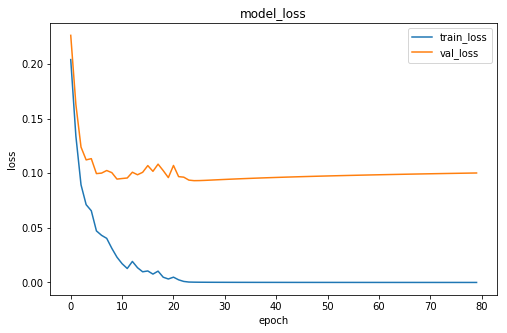

In [462]:
#勾配降下をMomentamで行った
#収束が早い
model2.plot_learning_curve()

In [439]:
model3 = ScratchDeepNeuralNetrowkClassifier2(n_features=n, batch_size=50, epoch=10, verbose=True)

In [453]:
model3.add("FC", 400, XavierInitializer(), Adam(lr=0.001, beta1=0.9, beta2=0.99))
model3.add("Tanh")
model3.add("FC", 400, XavierInitializer(), Adam(lr=0.001, beta1=0.9, beta2=0.99))
model3.add("Tanh")
model3.add("FC", 400, XavierInitializer(), Adam(lr=0.001, beta1=0.9, beta2=0.99))
model3.add("Tanh")
model3.add("FC", 200, XavierInitializer(), Adam(lr=0.001, beta1=0.9, beta2=0.99))
model3.add("Tanh")
model3.add("FC", 200, XavierInitializer(), Adam(lr=0.001, beta1=0.9, beta2=0.99))
model3.add("Tanh")
model3.add("FC", 100, XavierInitializer(), Adam(lr=0.001, beta1=0.9, beta2=0.99))
model3.add("Tanh")
model3.add("FC", 100, XavierInitializer(), Adam(lr=0.001, beta1=0.9, beta2=0.99))
model3.add("Tanh")
model3.add("FC", 10, XavierInitializer(), Adam(lr=0.001, beta1=0.9, beta2=0.99))
model3.add("Softmax")

In [454]:
model3.fit(X_train.astype("f"), y_train.astype("f"), X_val, y_val)

epoch:1 train_loss: 0.20047947947184244 val_loss: 0.21675984774798368 acc: 0.10216666666666667
epoch:2 train_loss: 0.147649112701416 val_loss: 0.1820328305480047 acc: 0.10216666666666667
epoch:3 train_loss: 0.10643446159362793 val_loss: 0.15016149951632807 acc: 0.10216666666666667
epoch:4 train_loss: 0.09567005157470704 val_loss: 0.1463943340791228 acc: 0.10216666666666667
epoch:5 train_loss: 0.06966157658894857 val_loss: 0.12999290392276278 acc: 0.10216666666666667
epoch:6 train_loss: 0.06545148118336995 val_loss: 0.1282480881990596 acc: 0.10216666666666667
epoch:7 train_loss: 0.056506895542144775 val_loss: 0.1140373295413604 acc: 0.10216666666666667
epoch:8 train_loss: 0.04453244137763977 val_loss: 0.12197214577978883 acc: 0.10216666666666667
epoch:9 train_loss: 0.0545103751818339 val_loss: 0.12754291767693154 acc: 0.10216666666666667
epoch:10 train_loss: 0.0439989321231842 val_loss: 0.12122807984219948 acc: 0.10216666666666667


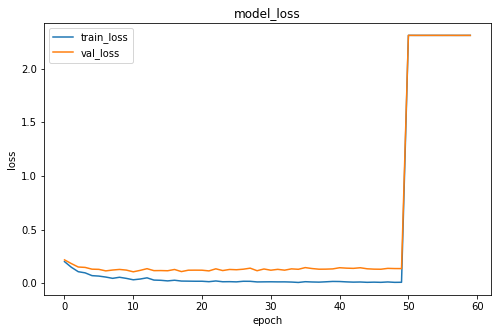

In [455]:
#勾配降下をadamで行った
#学習率高い(0.01)と収束しなかった。収束早い。beta2を下げると学習が進んだ時の学習率が低下？。　エポック５０で爆発した

model3.plot_learning_curve()

In [456]:
#テストのaccracy
test_pred = model3.predict(X_test)
model3.accuracy(y_test, test_pred)

0.101

# Momentum SGD
黒い線が損失関数の等高線を表していて、紫の星印で最小値となっているとします。Gradient Decent の更新式 (1.12) に従えば、傾きが最小の方向に突っ込んでいくためジグザグ運動が始まり、なかなか目的の星印にたどり着けなくなっています。しかし、よく観察してみると、行ったり来たりしている部分の"平均"をとればジグザグ運動は相殺されて前方への推進力（右図の青矢印）が得られそうです。これが、Momentum SGD の発想です。
https://qiita.com/deaikei/items/29d4550fa5066184329a
γは0.9 程度に設定されることが多いようです。



array([3, 3, 3, ..., 3, 3, 3])